In [139]:
# Loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast 

np.random.seed(1)

In [140]:
# Function to load and filter dataframes
def load_filtered_dataframe(filepath):
    df = pd.read_csv(filepath)
    # if filter_score:
    #     df = df[df[column_to_filter] >= threshold]
    df['box'] = df['box'].apply(str_to_list)
    return df

# Function to calculate the Intersection over Union (IoU) of two boxes
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

# Function to convert string representation of list into an actual list
def str_to_list(box_str):
    return ast.literal_eval(box_str)

# Function to compare benchmark and adversarial results and return the comparison results and statistics
def get_comparisons(benchmark_df, adv_df, iterations_to_check):
    comparison_results = []
    stats = {
        'correct detection': 0,
        'correct detection with >0.2 score drop': 0,
        'false negative': 0,
        'false positive': 0,
        'misclassification': 0,
        'total adv detections': 0,
        'total perturbation': 0
    }

    # Process the datasets
    for image_idx in adv_df['image_index'].unique():
        benchmark_subset = benchmark_df[benchmark_df['image_index'] == image_idx]
        adv_rows = adv_df[adv_df['image_index'] == image_idx]

        for iteration in iterations_to_check:
            iteration_adv_rows = adv_rows[adv_rows['iteration'] == iteration]
            stats['total adv detections'] += len(iteration_adv_rows)
            stats['total perturbation'] += iteration_adv_rows['total_perturbation'].sum()  # Sum up the perturbation for each iteration

            
            # Track the best score for each benchmark box matched with an adv box
            best_score_adv_for_benchmark = {index: (None, -1) for index in benchmark_subset.index}
            
            for _, adv_row in iteration_adv_rows.iterrows():
                adv_box = adv_row['box']
                best_iou = 0
                best_benchmark_index = None

                # Find the best match for this adv_box among all benchmark boxes
                for benchmark_index, benchmark_row in benchmark_subset.iterrows():
                    benchmark_box = benchmark_row['box']
                    iou = calculate_iou(adv_box, benchmark_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_benchmark_index = benchmark_index

                # If a match is found, check if this adv box has the highest score
                if best_iou >= 0.6:
                    _, best_score = best_score_adv_for_benchmark[best_benchmark_index]
                    if adv_row['score'] > best_score:
                        best_score_adv_for_benchmark[best_benchmark_index] = (adv_row, adv_row['score'])

            # Now, record the comparison results
            for benchmark_index, (adv_row, _) in best_score_adv_for_benchmark.items():
                benchmark_row = benchmark_subset.loc[benchmark_index]
                benchmark_box = benchmark_row['box']
                if adv_row is not None:
                    # Match found, determine if it's correct detection or misclassification
                    adv_box = adv_row['box']
                    iou = calculate_iou(adv_box, benchmark_box)
                    if adv_row['class'] == benchmark_row['class']:
                        stats['correct detection'] += 1
                        result_type = 'correct detection'
                        # score_difference = adv_row['score'] - benchmark_row['score']
                        # if score_difference < -0.2:
                        #     stats['correct detection with >0.2 score drop'] += 1
                    else:
                        stats['misclassification'] += 1
                        result_type = 'misclassification'
                    comparison_results.append({
                        'image_index': image_idx,
                        'iteration': iteration,
                        'benchmark_class': benchmark_row['class'],
                        'adv_class': adv_row['class'],
                        'benchmark_score': benchmark_row['score'],
                        'adv_score': adv_row['score'],
                        # 'score_difference': score_difference,
                        'iou': iou,
                        'result_type': result_type
                    })
                else:
                    # No match found, record as false negative
                    stats['false negative'] += 1
                    comparison_results.append({
                        'image_index': image_idx,
                        'iteration': iteration,
                        'benchmark_class': benchmark_row['class'],
                        'adv_class': 'no_detection',
                        'benchmark_score': benchmark_row['score'],
                        'adv_score': None,
                        'score_difference': None,
                        'iou': 0,
                        'result_type': 'false negative'
                    })

            # Check for any adv detections that weren't the best match and record as false positive
            for _, adv_row in iteration_adv_rows.iterrows():
                adv_box = adv_row['box']
                is_false_positive = True
                for benchmark_index, (best_match_adv_row, _) in best_score_adv_for_benchmark.items():
                    if best_match_adv_row is not None and best_match_adv_row.equals(adv_row):
                        is_false_positive = False
                        break
                if is_false_positive:
                    stats['false positive'] += 1
                    comparison_results.append({
                        'image_index': image_idx,
                        'iteration': iteration,
                        'benchmark_class': None,
                        'adv_class': adv_row['class'],
                        'benchmark_score': None,
                        'adv_score': adv_row['score'],
                        'score_difference': None,
                        'iou': 0,
                        'result_type': 'false positive'
                    })

    # Calculate total possible detections: number of benchmark boxes * number of iterations
    stats['total adv detections'] += stats['false negative']
    # Correct Detection Rate

    stats['correct detection rate'] = stats['correct detection'] / stats['total adv detections']
    stats['false negative rate'] = stats['false negative'] / stats['total adv detections']
    stats['false positive rate'] = stats['false positive'] / stats['total adv detections']
    stats['misclassification rate'] = stats['misclassification'] / stats['total adv detections']
    stats['average perturbation'] = stats['total perturbation'] / stats['total adv detections']
    stats['classification failure rate'] = 1 - stats['correct detection rate']
    
    return comparison_results, stats

# Function to print the detection statistics
def print_stats(stats):
    print("Detection Statistics:\n")
    for key, value in stats.items():
        if "rate" in key:
            print(f"{key.ljust(40)}: {value:.2%}")
        else:
            print(f"{key.ljust(40)}: {value}")

# Function to save the comparison results to a CSV file
def save_results(comparison_results, filepath):
    comparison_df = pd.DataFrame(comparison_results)
    comparison_df.to_csv(filepath, index=False)


In [141]:
iterations_to_check = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [142]:
# import pandas as pd

# # Read the existing CSV file
# df = pd.read_csv('/Users/yuxing/traffic-sign-detection/200img/rfcn_resnet_1/faster_rcnn_alg1_results.csv')

# # Determine the max image_index and iteration
# max_image_index = df['image_index'].max()
# max_iteration = df['iteration'].max()

# # Generate a DataFrame with all possible combinations of image_index and iteration
# all_combinations = pd.DataFrame([(i, j) for i in range(1, max_image_index + 1)
#                                  for j in range(1, max_iteration + 1)],
#                                 columns=['image_index', 'iteration'])

# # Merge the existing DataFrame with the new one
# df_full = all_combinations.merge(df, on=['image_index', 'iteration'], how='left')

# # Define a function to generate image names based on the image_index and iteration
# def generate_image_name(row):
#     return f'alg1_{str(row["image_index"]).zfill(3)}_itr{str(row["iteration"]).zfill(1)}.jpg'

# # Apply the function to fill in the image_name for missing entries
# df_full['image_name'] = df_full.apply(lambda row: generate_image_name(row) 
#                                       if pd.isnull(row['image_name']) else row['image_name'], axis=1)

# # Fill in the other missing values with 'no_detection' data
# df_full['class'] = df_full['class'].fillna('no_detection')
# df_full['score'] = df_full['score'].fillna(0)
# df_full['box'] = df_full['box'].fillna('[0, 0, 0, 0]')
# df_full['total_perturbation'] = df_full['total_perturbation'].fillna(0)
# df_full['max_perturbation'] = df_full['max_perturbation'].fillna(0)

# # Save the completed DataFrame back to CSV
# df_full.to_csv('detections_completed.csv', index=False)


# print(df_full)

In [143]:
# # benchmark_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn_resnet_101_0/faster_rcnn_alg0_results.csv"
# # adv_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn__resnet_random_0/adv_alg0_results.csv"

# # benchmark_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn_resnet_0/faster_rcnn_alg0_results.csv"
# # adv_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn_resnet_101_1/faster_rcnn_alg1_results.csv"

# # benchmark_filepath = "/Users/yuxing/traffic-sign-detection/200img/ssd_mobilenet_0/faster_rcnn_alg0_results.csv"
# # adv_filepath = "/Users/yuxing/traffic-sign-detection/200img/ssd_mobilenet_1/faster_rcnn_alg1_results.csv"

# benchmark_filepath = "/Users/yuxing/traffic-sign-detection/200img/ssd_mobilenet_0/faster_rcnn_alg0_results.csv"
# adv_filepath = "/Users/yuxing/traffic-sign-detection/200img/ssd_mobilenet_random_0/adv_alg0_results.csv"


# # Load and filter dataframes
# benchmark_df = load_filtered_dataframe(benchmark_filepath)
# adv_df = load_filtered_dataframe(adv_filepath)
# adv_df.loc[adv_df['score'] < 0.5, 'class'] = 'no_detection'
# adv_df = adv_df[adv_df['iteration'].isin(iterations_to_check)]

# # Get comparisons and stats
# comparison_results, stats = get_comparisons(benchmark_df, adv_df, iterations_to_check)

# # Print stats and save results
# print_stats(stats)
# save_results(comparison_results, '/Users/yuxing/traffic-sign-detection/200img/comparison_results1.csv')

# Benchmark

In [144]:
# Example usage of the functions
benchmark_filepath = "/Users/yuxing/traffic-sign-detection/200img/test_image_results/200_images_0/adv_alg0_results.csv"
adv_filepath = "/Users/yuxing/traffic-sign-detection/200img/200_images_1/adv_alg1_results.csv"

# Load and filter dataframes
benchmark_df = load_filtered_dataframe(benchmark_filepath)
adv_df = load_filtered_dataframe(adv_filepath)
adv_df.loc[adv_df['score'] < 0.5, 'class'] = 'no_detection'

# Initialize a dictionary to hold stats for each iteration
iteration_stats = {}

# Process each iteration separately
for iteration in iterations_to_check:
    filtered_adv_df = adv_df[adv_df['iteration'] == iteration]
    comparison_results, stats = get_comparisons(benchmark_df, filtered_adv_df, [iteration])
    iteration_stats[iteration] = stats

# Extract iterations and their corresponding classification failure rates
iterations = list(iteration_stats.keys())
failure_rates = [iteration_stats[iteration]['classification failure rate'] for iteration in iterations_to_check]
failure_rates_percent = [rate * 100 for rate in failure_rates]

In [145]:
# Example 3 faster__rcnn_v2_random
benchmark3_filepath = "/Users/yuxing/traffic-sign-detection/200img/test_image_results/200_images_0/adv_alg0_results.csv"
adv3_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_v2_random_0/adv_alg0_results.csv"

benchmark3_df = load_filtered_dataframe(benchmark3_filepath)
adv3_df = load_filtered_dataframe(adv3_filepath)
adv3_df.loc[adv3_df['score'] < 0.5, 'class'] = 'no_detection'

# Initialize a dictionary to hold stats for each iteration for example 3
iteration_stats3 = {}

# Process each iteration separately for example 3
for iteration in iterations_to_check:
    filtered_adv3_df = adv3_df[adv3_df['iteration'] == iteration]
    comparison_results3, stats3 = get_comparisons(benchmark3_df, filtered_adv3_df, [iteration])
    iteration_stats3[iteration] = stats3

failure_rates_percent3 = [iteration_stats3[iteration]['classification failure rate'] * 100 for iteration in iterations_to_check]

# faster_rcnn_resnet_101

In [146]:
# Example 2 faster_rcnn_resnet_101
benchmark2_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn_resnet_0/faster_rcnn_alg0_results.csv"
adv2_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn_resnet_101_1/detections_completed.csv"

benchmark2_df = load_filtered_dataframe(benchmark2_filepath)
adv2_df = load_filtered_dataframe(adv2_filepath)
adv2_df.loc[adv2_df['score'] < 0.5, 'class'] = 'no_detection'

# Initialize a dictionary to hold stats for each iteration for example 2
iteration_stats2 = {}

# Process each iteration separately for example 2
for iteration in iterations_to_check:
    filtered_adv2_df = adv2_df[adv2_df['iteration'] == iteration]
    comparison_results2, stats2 = get_comparisons(benchmark2_df, filtered_adv2_df, [iteration])
    iteration_stats2[iteration] = stats2

failure_rates_percent2 = [iteration_stats2[iteration]['classification failure rate'] * 100 for iteration in iterations_to_check]

In [147]:
# Example 4 faster_rcnn_resnet_101_random
benchmark4_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn_resnet_0/faster_rcnn_alg0_results.csv"
adv4_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn__resnet_random_0/adv_alg0_results.csv"


benchmark4_df = load_filtered_dataframe(benchmark4_filepath)
adv4_df = load_filtered_dataframe(adv4_filepath)
adv4_df.loc[adv4_df['score'] < 0.5, 'class'] = 'no_detection'

# Initialize a dictionary to hold stats for each iteration for example 4
iteration_stats4 = {}

# Process each iteration separately for example 4
for iteration in iterations_to_check:
    filtered_adv4_df = adv4_df[adv4_df['iteration'] == iteration]
    comparison_results4, stats4 = get_comparisons(benchmark4_df, filtered_adv4_df, [iteration])
    iteration_stats4[iteration] = stats4

failure_rates_percent4 = [iteration_stats4[iteration]['classification failure rate'] * 100 for iteration in iterations_to_check]


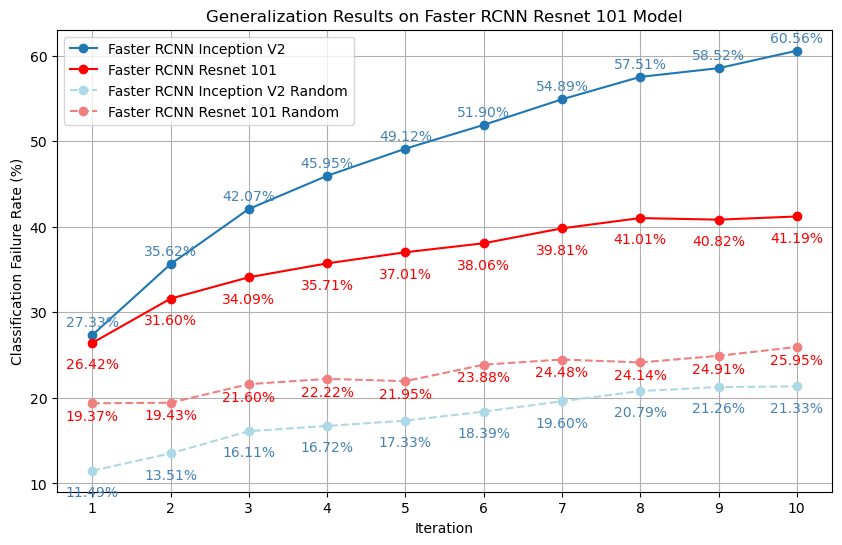

In [148]:
plt.figure(figsize=(10, 6))

# Plot for the first example
plt.plot(iterations, failure_rates_percent, marker='o', label='Faster RCNN Inception V2')
for i, rate in zip(iterations, failure_rates_percent):
    plt.text(i, rate + 1, f"{rate:.2f}%", ha='center', color='Steelblue')

# Plot for the second example
plt.plot(iterations, failure_rates_percent2, marker='o', color='red', label='Faster RCNN Resnet 101')
for i, rate in zip(iterations, failure_rates_percent2):
    plt.text(i, rate - 3, f"{rate:.2f}%", ha='center', color='red')

# Plot for the second example
plt.plot(iterations, failure_rates_percent3, marker='o', linestyle='--', color='lightblue', label='Faster RCNN Inception V2 Random')
for i, rate in zip(iterations, failure_rates_percent3):
    plt.text(i, rate - 3, f"{rate:.2f}%", ha='center', color='Steelblue')

# Plot for the second example
plt.plot(iterations, failure_rates_percent4, marker='o', linestyle='--', color='lightcoral', label='Faster RCNN Resnet 101 Random')
for i, rate in zip(iterations, failure_rates_percent4):
    plt.text(i, rate - 2, f"{rate:.2f}%", ha='center', color='red')

plt.xticks(iterations)
plt.title('Generalization Results on Faster RCNN Resnet 101 Model')
plt.xlabel('Iteration')
plt.ylabel('Classification Failure Rate (%)')
plt.grid(True)
plt.legend()
plt.show()

# ssd_mobilenet

In [149]:
benchmark2_filepath = "/Users/yuxing/traffic-sign-detection/200img/ssd_mobilenet_0/faster_rcnn_alg0_results.csv"
adv2_filepath = "/Users/yuxing/traffic-sign-detection/200img/ssd_mobilenet_1/detections_completed.csv"

benchmark2_df = load_filtered_dataframe(benchmark2_filepath)
adv2_df = load_filtered_dataframe(adv2_filepath)
adv2_df.loc[adv2_df['score'] < 0.5, 'class'] = 'no_detection'

# Initialize a dictionary to hold stats for each iteration for example 2
iteration_stats2 = {}

# Process each iteration separately for example 2
for iteration in iterations_to_check:
    filtered_adv2_df = adv2_df[adv2_df['iteration'] == iteration]
    comparison_results2, stats2 = get_comparisons(benchmark2_df, filtered_adv2_df, [iteration])
    iteration_stats2[iteration] = stats2

failure_rates_percent2 = [iteration_stats2[iteration]['classification failure rate'] * 100 for iteration in iterations_to_check]

In [150]:
benchmark4_filepath = "/Users/yuxing/traffic-sign-detection/200img/ssd_mobilenet_0/faster_rcnn_alg0_results.csv"
adv4_filepath = "/Users/yuxing/traffic-sign-detection/200img/ssd_mobilenet_random_0/adv_alg0_results.csv"

benchmark4_df = load_filtered_dataframe(benchmark4_filepath)
adv4_df = load_filtered_dataframe(adv4_filepath)
adv4_df.loc[adv4_df['score'] < 0.5, 'class'] = 'no_detection'

# Initialize a dictionary to hold stats for each iteration for example 4
iteration_stats4 = {}

# Process each iteration separately for example 4
for iteration in iterations_to_check:
    filtered_adv4_df = adv4_df[adv4_df['iteration'] == iteration]
    comparison_results4, stats4 = get_comparisons(benchmark4_df, filtered_adv4_df, [iteration])
    iteration_stats4[iteration] = stats4

failure_rates_percent4 = [iteration_stats4[iteration]['classification failure rate'] * 100 for iteration in iterations_to_check]

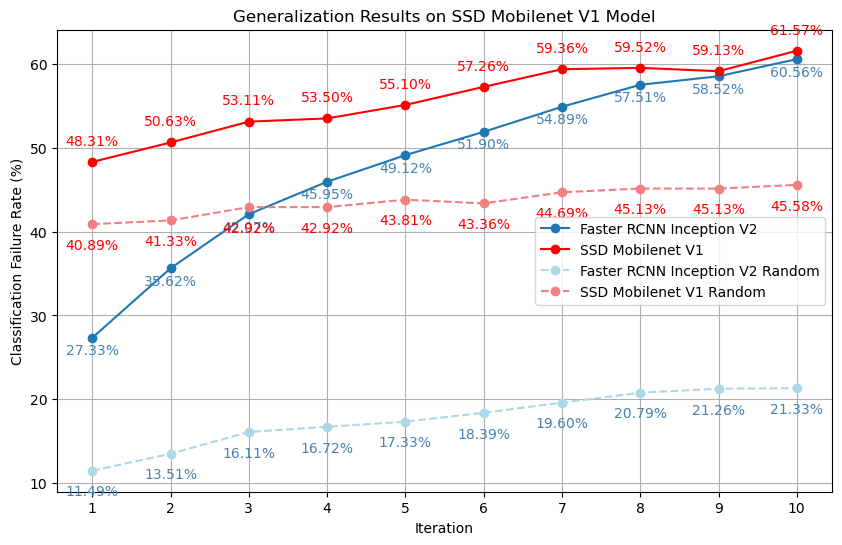

In [151]:
plt.figure(figsize=(10, 6))

# Plot for the first example
plt.plot(iterations, failure_rates_percent, marker='o', label='Faster RCNN Inception V2')
for i, rate in zip(iterations, failure_rates_percent):
    plt.text(i, rate - 2, f"{rate:.2f}%", ha='center', color='Steelblue')

# Plot for the second example
plt.plot(iterations, failure_rates_percent2, marker='o', color='red', label='SSD Mobilenet V1')
for i, rate in zip(iterations, failure_rates_percent2):
    plt.text(i, rate + 2, f"{rate:.2f}%", ha='center', color='red')

# Plot for the second example
plt.plot(iterations, failure_rates_percent3, marker='o', linestyle='--', color='lightblue', label='Faster RCNN Inception V2 Random')
for i, rate in zip(iterations, failure_rates_percent3):
    plt.text(i, rate - 3, f"{rate:.2f}%", ha='center', color='Steelblue')

# Plot for the second example
plt.plot(iterations, failure_rates_percent4, marker='o', linestyle='--', color='lightcoral', label='SSD Mobilenet V1 Random')
for i, rate in zip(iterations, failure_rates_percent4):
    plt.text(i, rate - 3, f"{rate:.2f}%", ha='center', color='red')

plt.xticks(iterations)
plt.title('Generalization Results on SSD Mobilenet V1 Model')
plt.xlabel('Iteration')
plt.ylabel('Classification Failure Rate (%)')
plt.grid(True)
plt.legend()
plt.show()

# rfcn_resnet_101

In [152]:
benchmark2_filepath = "/Users/yuxing/traffic-sign-detection/200img/rfcn_resnet_0/faster_rcnn_alg0_results.csv"
adv2_filepath = "/Users/yuxing/traffic-sign-detection/200img/rfcn_resnet_1/detections_completed.csv"

benchmark2_df = load_filtered_dataframe(benchmark2_filepath)
adv2_df = load_filtered_dataframe(adv2_filepath)
adv2_df.loc[adv2_df['score'] < 0.5, 'class'] = 'no_detection'

# Initialize a dictionary to hold stats for each iteration for example 2
iteration_stats2 = {}

# Process each iteration separately for example 2
for iteration in iterations_to_check:
    filtered_adv2_df = adv2_df[adv2_df['iteration'] == iteration]
    comparison_results2, stats2 = get_comparisons(benchmark2_df, filtered_adv2_df, [iteration])
    iteration_stats2[iteration] = stats2

failure_rates_percent2 = [iteration_stats2[iteration]['classification failure rate'] * 100 for iteration in iterations_to_check]

In [153]:
benchmark4_filepath = "/Users/yuxing/traffic-sign-detection/200img/rfcn_resnet_0/faster_rcnn_alg0_results.csv"
adv4_filepath = "/Users/yuxing/traffic-sign-detection/200img/rfcn_resnet_random_0/adv_alg0_results.csv"

benchmark4_df = load_filtered_dataframe(benchmark4_filepath)
adv4_df = load_filtered_dataframe(adv4_filepath)
adv4_df.loc[adv4_df['score'] < 0.5, 'class'] = 'no_detection'

# Initialize a dictionary to hold stats for each iteration for example 4
iteration_stats4 = {}

# Process each iteration separately for example 4
for iteration in iterations_to_check:
    filtered_adv4_df = adv4_df[adv4_df['iteration'] == iteration]
    comparison_results4, stats4 = get_comparisons(benchmark4_df, filtered_adv4_df, [iteration])
    iteration_stats4[iteration] = stats4

failure_rates_percent4 = [iteration_stats4[iteration]['classification failure rate'] * 100 for iteration in iterations_to_check]

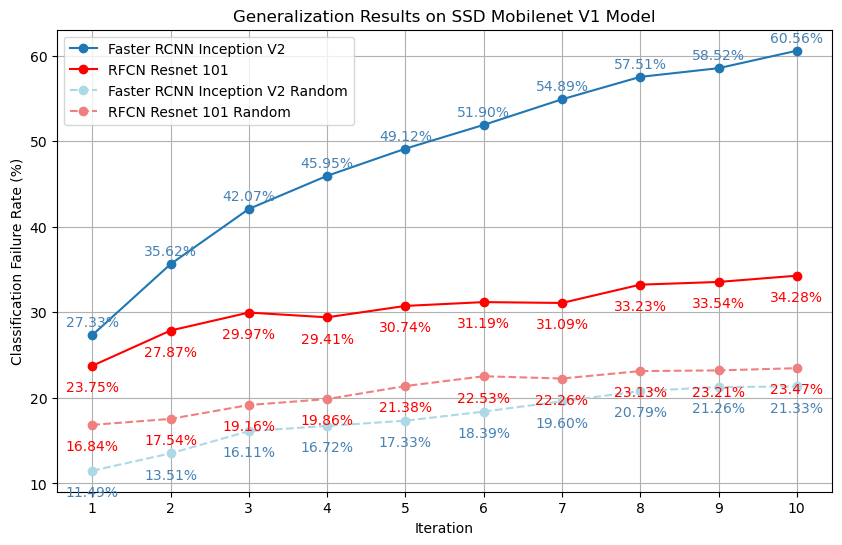

In [154]:
plt.figure(figsize=(10, 6))

# Plot for the first example
plt.plot(iterations, failure_rates_percent, marker='o', label='Faster RCNN Inception V2')
for i, rate in zip(iterations, failure_rates_percent):
    plt.text(i, rate + 1, f"{rate:.2f}%", ha='center', color='Steelblue')

# Plot for the second example
plt.plot(iterations, failure_rates_percent2, marker='o', color='red', label='RFCN Resnet 101')
for i, rate in zip(iterations, failure_rates_percent2):
    plt.text(i, rate - 3, f"{rate:.2f}%", ha='center', color='red')

# Plot for the second example
plt.plot(iterations, failure_rates_percent3, marker='o', linestyle='--', color='lightblue', label='Faster RCNN Inception V2 Random')
for i, rate in zip(iterations, failure_rates_percent3):
    plt.text(i, rate - 3, f"{rate:.2f}%", ha='center', color='Steelblue')

# Plot for the second example
plt.plot(iterations, failure_rates_percent4, marker='o', linestyle='--', color='lightcoral', label='RFCN Resnet 101 Random')
for i, rate in zip(iterations, failure_rates_percent4):
    plt.text(i, rate - 3, f"{rate:.2f}%", ha='center', color='red')

plt.xticks(iterations)
plt.title('Generalization Results on RFCN Resnet 101 Model')
plt.xlabel('Iteration')
plt.ylabel('Classification Failure Rate (%)')
plt.grid(True)
plt.legend()
plt.show()